In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, SimpleRNN, TimeDistributed
from keras import optimizers

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
raw_data = np.loadtxt(open("EEG.csv", "rb"), delimiter=",", skiprows=0)
X_raw = raw_data[:,:-1]

# Data cleaning on X
upper_threshold = 4800
lower_threshold = 3800
too_big = X_raw>upper_threshold
too_small = X_raw<lower_threshold
X_cleaned = np.copy(X_raw)
X_cleaned[too_big] = upper_threshold
X_cleaned[too_small] = lower_threshold

X_toPCA = (X_cleaned - np.mean(X_cleaned)) / np.std(X_cleaned)
y = raw_data[:,-1]

In [3]:
pca = PCA(n_components=3)
X = pca.fit_transform(X_toPCA)

In [4]:
np.sum(pca.explained_variance_ratio_[:3])

0.81833831968396098

In [5]:
num_train = 7000
num_val = 7000
X_train = X[:num_train,:]
y_train = y[:num_train]
X_val = X[num_train:num_train+num_val,:]
y_val = y[num_train:num_train+num_val]
X_test = X[num_train+num_val:,:]
y_test = y[num_train+num_val:]

In [20]:
batch_size = 100
train_batch_length = int(num_train/batch_size)
X_train_batch = np.zeros((batch_size,train_batch_length,X.shape[-1]))
y_train_batch = np.zeros((batch_size,train_batch_length))
for i in range(train_batch_length):
    X_train_batch[:,i,:] = X_train[i*batch_size:(i+1)*batch_size,:]
    y_train_batch[:,i] = y_train[i*batch_size:(i+1)*batch_size]

val_batch_length = int(num_val/batch_size)
X_val_batch = np.zeros((batch_size,val_batch_length,X.shape[-1]))
y_val_batch = np.zeros((batch_size,val_batch_length))
for i in range(val_batch_length):
    X_val_batch[:,i,:] = X_val[i*batch_size:(i+1)*batch_size,:]
    y_val_batch[:,i] = y_val[i*batch_size:(i+1)*batch_size]
y_train_batch = y_train_batch.reshape((y_train_batch.shape[0],y_train_batch.shape[1],1))
y_val_batch = y_val_batch.reshape((y_val_batch.shape[0],y_val_batch.shape[1],1))

In [24]:
model = Sequential()
model.add(SimpleRNN(256,return_sequences=True, stateful = True,activation = 'tanh',batch_input_shape=X_train_batch.shape))
model.add(Dropout(0.5))
#model.add(SimpleRNN(128,return_sequences=True, stateful = True,activation = 'tanh'))
#model.add(Dropout(0.5))
#model.add(SimpleRNN(64,return_sequences=True, stateful = True,activation = 'tanh'))
#model.add(Dropout(0.5))
model.add(SimpleRNN(32,return_sequences=True, stateful = True,activation = 'tanh'))
model.add(Dropout(0.5))
model.add(SimpleRNN(16,return_sequences=True, stateful = True,activation = 'tanh'))
model.add(Dropout(0.5))

model.add(TimeDistributed(Dense(1,activation = "sigmoid")))
adam = optimizers.Adam(lr=0.0001,decay=1e-6)
model.compile(optimizer = adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [25]:
history = model.fit(X_train_batch, y_train_batch,validation_data = (X_val_batch,y_val_batch), epochs=50, batch_size=batch_size)

Train on 100 samples, validate on 100 samples
Epoch 1/50
100/100 [==============================] - 1s - loss: 0.8640 - acc: 0.4866 - val_loss: 0.7921 - val_acc: 0.4600
Epoch 2/50
100/100 [==============================] - 0s - loss: 0.8473 - acc: 0.5087 - val_loss: 0.7884 - val_acc: 0.4624
Epoch 3/50
100/100 [==============================] - 0s - loss: 0.8212 - acc: 0.5150 - val_loss: 0.7840 - val_acc: 0.4623
Epoch 4/50
100/100 [==============================] - 0s - loss: 0.8067 - acc: 0.5331 - val_loss: 0.7825 - val_acc: 0.4607
Epoch 5/50
100/100 [==============================] - 0s - loss: 0.7757 - acc: 0.5519 - val_loss: 0.7776 - val_acc: 0.4649
Epoch 6/50
100/100 [==============================] - 0s - loss: 0.7421 - acc: 0.5733 - val_loss: 0.7759 - val_acc: 0.4747
Epoch 7/50
100/100 [==============================] - 0s - loss: 0.7074 - acc: 0.5994 - val_loss: 0.7730 - val_acc: 0.4804
Epoch 8/50
100/100 [==============================] - 0s - loss: 0.6769 - acc: 0.6271 - val_l

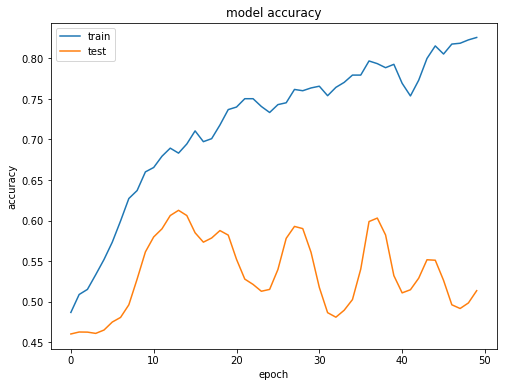

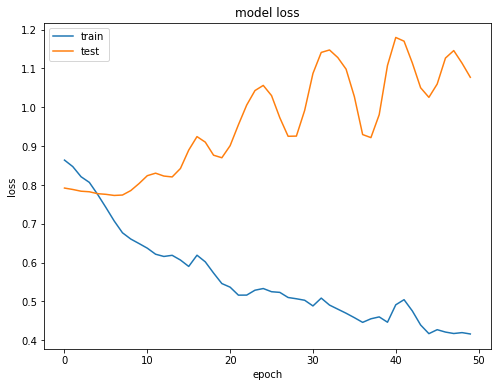

In [26]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()